In [1]:
from types import TracebackType
import torch
import os
import numpy as np

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import glob
from pycocotools.coco import COCO
import  skimage.io as sio
from skimage.draw import polygon
import matplotlib.pyplot as plt
import time


DATA_ROOT = "./data/"
path_list = os.listdir(DATA_ROOT)

# Transform (Preprocessing)
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),     # Imagenet mean, std
])

'''
DATA: PoseTrack

Custom Dataset: PoseTrackDataset

    return: Video_Num, Image(T), Image(T+1), Annotation(T), Annotation(T+1)

'''

class PoseTrackDataset(Dataset):
    def __init__(self, data_root = DATA_ROOT, transform = transform):
        self.transform = transform
        self.data_root = data_root
        self.image_dir_path = os.path.join(self.data_root, "images/train")
        self.annot_path = os.path.join(self.data_root, "annotations/train")
        self.annot_list = [path + ".json" for path in os.listdir(self.image_dir_path) if path + ".json" in os.listdir(self.annot_path)]
        self.image_dir_path_with_annot = [path for path in os.listdir(self.image_dir_path) if path + ".json" in os.listdir(self.annot_path)]


        self.all_image_list = []
        self.coco_object = []

        self.pair_img_annot = []

        

    def _get_images_per_video(self, json_file_path):
        coco = COCO(os.path.join(self.annot_path, json_file_path))
        img_ids = coco.getImgIds()  # image ids (여러개)
        imgs = coco.loadImgs(img_ids)
        # vid_id = np.unique([img['vid_id'] for img in imgs])

        posetrack_images = []
        for img in imgs:
            if not img['is_labeled']:  # or img['vid_id'] != '000015':  # Uncomment to filter for a sequence.
                pass
            else:
                posetrack_images.append(img)
        return posetrack_images, coco

    def _create_all_img_list(self):
        for json_file_path in self.annot_list:
            imgs, coco = self._get_images_per_video(json_file_path)
            self.all_image_list.append(imgs)
            self.coco_object.append(coco)
            

    def _get_keypoints_img(self, img_data, track_id, anns):
        
        # Load Image
        img = sio.imread(os.path.join(self.data_root, img_data['file_name']))
        # Visualize ignore regions if present.
        if 'ignore_regions_x' in img_data.keys():
            for region_x, region_y in zip(img_data['ignore_regions_x'], img_data['ignore_regions_y']):
                rr, cc = polygon(region_y, region_x, img.shape)
                img[rr, cc, 1] = 128 + img[rr, cc, 1]/2

        if len(anns) == 0:
            return 0
        if 'segmentation' in anns[0] or 'keypoints' in anns[0]:
            datasetType = 'instances'
        elif 'caption' in anns[0]:
            datasetType = 'captions'
        else:
            raise Exception('datasetType not supported')

        if datasetType == 'instances':
            for ann in anns:
                if ann["track_id"] != track_id:
                    continue

                if 'keypoints' in ann and type(ann['keypoints']) == list:
                    kp = np.array(ann['keypoints'])
        
        return (img, kp)

    def _create_pair_img_annot_per_vid(self):
        for idx, vid_path in enumerate(self.image_dir_path_with_annot):
            if idx + 1 == 2:
                break
            print("Processing {}th video".format(idx + 1))
            coco = self.coco_object[idx]
            num_valid_img = len(self.all_image_list[idx])

            first_image_data = self.all_image_list[idx][0]
            ann_ids = coco.getAnnIds(imgIds = first_image_data['id'])
            anns = coco.loadAnns(ann_ids)

            num_human = np.unique([ann['track_id'] for ann in anns])
            
            for i, frame in enumerate(self.all_image_list[idx]):
                print("-Processing {}th video".format(i + 1))

                if i + 2 >= num_valid_img:
                    break
                image_data_0 = self.all_image_list[idx][i]
                ann_ids_0 = coco.getAnnIds(imgIds = image_data_0['id'])
                anns_0 = coco.loadAnns(ann_ids_0)

                image_data_1 = self.all_image_list[idx][i+1]
                ann_ids_1 = coco.getAnnIds(imgIds = image_data_1['id'])
                anns_1 = coco.loadAnns(ann_ids_1)

                human_0 = np.unique([ann['track_id'] for ann in anns_0])
                human_1 = np.unique([ann['track_id'] for ann in anns_1])

                for track_id in num_human:
                    if track_id not in human_0 or track_id not in human_1:
                        continue
                    self.pair_img_annot.append((self._get_keypoints_img(self.all_image_list[idx][i], track_id, anns), 
                                               self._get_keypoints_img(self.all_image_list[idx][i+1], track_id, anns)))

    def __getitem__(self, idx):
        return self.pair_img_annot[idx]

    def __len__(self):
        return len(self.pair_img_annot)

dataset = PoseTrackDataset()
dataset._create_all_img_list()
dataset._create_pair_img_annot_per_vid()

print("Test: {}".format(dataset[0]))
print("Dataset Length: {}".format(len(dataset)))

def showAnns(kp):
    """
    Display the specified annotations.
    :param anns (array of object): annotations to display
    :return: None
    """
    from matplotlib.collections import PatchCollection

    ax = plt.gca()
    ax.set_autoscale_on(False)
    polygons = []
    color = []
    np.random.seed(1)
    color_coeffs = np.random.random((31, 3))
    c_assoc =  1* 97 % 31
    c = (color_coeffs[c_assoc:c_assoc+1, :]*0.6+0.4).tolist()[0]

    # turn skeleton into zero-based index
    sks = np.array([[16, 14], 
                [14, 12], 
                [17, 15], 
                [15, 13], 
                [12, 13], 
                [ 6, 12], 
                [ 7, 13], 
                [ 6,  7], 
                [ 6,  8], 
                [ 7,  9], 
                [ 8, 10], 
                [ 9, 11], 
                [ 2,  3], 
                [ 1,  2], 
                [ 1,  3], 
                [ 2,  4], 
                [ 3,  5], 
                [ 4,  6], 
                [ 5,  7]])-1
    kp = np.array(kp)
    x = kp[0::3]
    y = kp[1::3]
    v = kp[2::3]
    for sk in sks:
        if np.all(v[sk]>0):
            plt.plot(x[sk],y[sk], linewidth=3, color=c)
    plt.plot(x[v>0], y[v>0],'o',markersize=8, markerfacecolor=c, markeredgecolor='k',markeredgewidth=2)
    plt.plot(x[v>1], y[v>1],'o',markersize=8, markerfacecolor=c, markeredgecolor=c, markeredgewidth=2)

    p = PatchCollection(polygons, facecolor=color, linewidths=0, alpha=0.4)
    ax.add_collection(p)
    p = PatchCollection(polygons, facecolor='none', edgecolors=color, linewidths=2)
    ax.add_collection(p)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
load

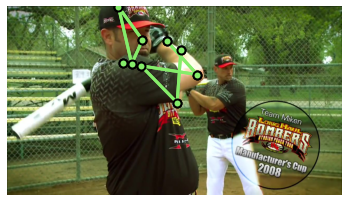

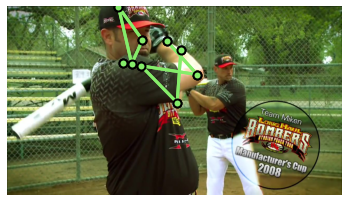

In [3]:
from IPython import display
for idx, ((image0, kp0), (image1, kp1)) in enumerate(dataset.pair_img_annot):
    if idx + 1 == 5:
        break

    print("{}th pair image".format(idx + 1))
    print("kp0: {}".format(kp0))
    print("kp1: {}".format(kp1))
    plt.clf()
    plt.axis('off')
    plt.imshow(image0)
    showAnns(kp0)
    print("Next pair image")
    time.sleep(5)
    plt.axis('off')
    plt.imshow(image1)
    showAnns(kp1)

    display.clear_output(wait=True)
    display.display(plt.gcf())

In [6]:
a = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]
a[0::3][0] = 3

In [7]:
a

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]